# Clustering: Using the City of Toronto's Open Data to Analyze Councillor Voting Behaviour

### by Mark M<sup>c</sup>Carthy

I find myself in a position where my previous work is proprietary to my former employers, and I don't have much of a publicly available portfolio. To fix this, I wanted to find a sizeable public dataset then perform a non-trivial analysis, and to have **fun** doing it! In this project I used attendance data from the city councils of Toronto to study councillor absenteeism, and you can read about this in [another notebook](https://github.com/markomemos/councillors/blob/master/councillor_attendance.ipynb). I later wrote a clustering algorithm to group councillors based their voting records, developed it with Toronto data and evaluated it with Calgary data, and you can see the analysis below. 

The clustering algorithm was a heirarchichal agglomerative weight-based non-euclidean clustering using the sum of the variances in the clusters as the objective function to be minimized. A complex imputation was also performed on sparse, non-euclidean data with highly non-uniform uncertainties, with the intent of optimizing the result of the clustering to come.

Many municipalities have open source data available on a very wide number of topics. For example, in Toronto you can find data on everything from all public city-provided wifi, to red-light camera locations, to restaurant food inspection results. Here are the data for [Toronto](https://open.toronto.ca/) and [Calgary](https://data.calgary.ca/).

## Councillor clustering based on voting behaviour

Now that we've grown comfortable with the open data, let's see if we can do something more sophisticated. If we look at voting records rather than just attendance records, we can try to group councillors together based on how similar they are from each other. To see if we've done a good job clustering, I built everything that follows using the Toronto council voting data. When I was satisfied that the results looked reasonable, I tested to see if it worked using the Calgary council voting data.<br>

Unfortunately we see that there is a substantial difference between the two datasets. Toronto's voting records go back to 2006, whereas Calgary's only go back to 2017. To go back further with Calgary's data, it looks like I'd have to do some pdf scraping of the meeting minutes. Since this is supposed to be a ***fun*** project, I'll just let it be. If I were to do this again, I'd try to find a better train-validation-test breakdown.

---

Here is our roadmap for what is to come:
1. Data ingestion: filtering and processing
2. Compute dissimilarity matrix
3. Impute missing values in dissimilarity matrix
4. Cluster

---

### Data ingestion: filtering and processing

First we need to import our modules. Given the scale of this project, pandas seems to be an appropriate choice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
print('pandas version = '+pd.__version__)
print('numpy version = '+np.__version__)

pandas version = 2.0.3
numpy version = 1.24.3


Next we load our data. I've decided to duplicate all our dataframes into two sets, a Toronto set and a Calgary set. Had this been a bigger project, I'd love to turn all these into function calls or some kind of sklearn pipelines, but that's beyond the scope for now.

In [2]:
# Let's label our two datasets, in case I forget my naming scheme
city_dict = {0:'Toronto',1:'Calgary'}

# Don't judge my pathname!
dir_name = '/Users/markmccarthy/Documents/coding_fun/toronto_dsci/councillors/'
filenames = {}

# Toronto data 
short_filenames = [
    'member-voting-record-2022-2026.csv',
    'member-voting-record-2018-2022.csv',
    'member-voting-record-2014-2018.csv',
    'member-voting-record-2010-2014.csv',
    'member-voting-record-2006-2010.csv'
]
filenames[0] = [dir_name + f for f in short_filenames] 

# Calgary data
filenames[1] = [dir_name + 'Council_and_Committee_Votes_20231024.csv']

In [3]:
raw_voting_df = {}

# Toronto
raw_voting_df[0] = pd.concat((pd.read_csv(f, index_col = '_id') for f in filenames[0]), ignore_index=True)

#Calgary
raw_voting_df[1] = pd.read_csv(filenames[1][0])

In [4]:
# Get a sense of what the data looks like
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    display(df.head())
    display(df.describe(include='all'))
    print(' ')

City = Toronto


,Term,First Name,Last Name,Committee,Date/Time,Agenda Item #,Agenda Item Title,Motion Type,Vote,Result,Vote Description
0,2022-2026,Paul,Ainslie,City Council,NaN,2023.FM1.8,Election of the Speaker and Deputy Speaker,Nomination of a Member,Yes,"Carried, 25-1",Majority required - Appoint Councillor Nunziat...
1,2022-2026,Brad,Bradford,City Council,NaN,2023.FM1.8,Election of the Speaker and Deputy Speaker,Nomination of a Member,Yes,"Carried, 25-1",Majority required - Appoint Councillor Nunziat...
2,2022-2026,Alejandra,Bravo,City Council,NaN,2023.FM1.8,Election of the Speaker and Deputy Speaker,Nomination of a Member,Yes,"Carried, 25-1",Majority required - Appoint Councillor Nunziat...
3,2022-2026,Jon,Burnside,City Council,NaN,2023.FM1.8,Election of the Speaker and Deputy Speaker,Nomination of a Member,Yes,"Carried, 25-1",Majority required - Appoint Councillor Nunziat...
4,2022-2026,Shelley,Carroll,City Council,NaN,2023.FM1.8,Election of the Speaker and Deputy Speaker,Nomination of a Member,Yes,"Carried, 25-1",Majority required - Appoint Councillor Nunziat...


,Term,First Name,Last Name,Committee,Date/Time,Agenda Item #,Agenda Item Title,Motion Type,Vote,Result,Vote Description
count,707546,707546,707546,707546,28840,707546,707546,707546,707546,707546,707546
unique,5,74,87,57,784,8576,7718,52,3,1027,15456
top,2010-2014,John,Ford,City Council,2010-03-09T00:00:00,2011.EX10.1,Introduction and Enactment of General Bills an...,Adopt Item,Yes,"Carried, 39-0",Majority required
freq,358814,37559,23840,683450,1118,4545,31696,167403,507330,19626,16363


 
City = Calgary


,MeetingType,MeetingDate,Resolution,Voter,Vote,Result
0,Audit Committee,2022/01/20,"That with respect to Report AC2022-0042, the f...",Lori Caltagirone,Yes,MOTION CARRIED
1,Audit Committee,2022/01/20,"That with respect to Report AC2022-0042, the f...",Karen Kim,Yes,MOTION CARRIED
2,Audit Committee,2022/01/20,"That with respect to Report AC2022-0042, the f...",John (Richard) Pootmans,Yes,MOTION CARRIED
3,Audit Committee,2022/01/20,"That with respect to Report AC2022-0042, the f...",Jennifer Wyness,Yes,MOTION CARRIED
4,Audit Committee,2022/01/20,"That with respect to Report AC2022-0042, the f...",Terry Wong,Yes,MOTION CARRIED


,MeetingType,MeetingDate,Resolution,Voter,Vote,Result
count,28255,28255,28255,28255,28255,28255
unique,13,187,2312,51,3,2
top,Combined Meeting of Council,2022/03/29,That Recommendation 1 contained in Report C202...,Sean Chu,Yes,MOTION CARRIED
freq,15861,1336,30,1659,25348,26825


In [5]:
# Check for duplicated data
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    print(f'Number of duplicated rows = {df[df.duplicated()].shape[0]}')
    print(' ') # could use more whitespace

City = Toronto
Number of duplicated rows = 2037
 
City = Calgary
Number of duplicated rows = 1411
 


In [6]:
# Check for missing data
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    display(df.isnull().sum().to_frame().rename(columns={0:'Nulls'}))
    print(' ') # could use more whitespace

City = Toronto


,Nulls
Term,0
First Name,0
Last Name,0
Committee,0
Date/Time,678706
Agenda Item #,0
Agenda Item Title,0
Motion Type,0
Vote,0
Result,0


 
City = Calgary


,Nulls
MeetingType,0
MeetingDate,0
Resolution,0
Voter,0
Vote,0
Result,0


We can see that the Toronto and Calgary data have a lot in common. Both have varied `Committee` or `MeetingType` including council votes and committee votes, and each row represents each councillor at each vote. We can already see some features of the data, for example, the Toronto `Date/Time` column is mostly empty, so we should be careful if ever using it.

---

Now let's dive into the peculiarities of our data and compile a list of clean-up actions we'll need to perform later:

In [7]:
for city_id, df in raw_voting_df.items():
    print(f'City = {city_dict[city_id]}')
    # it's quite convenient that the column name 'Vote' appears in both datasets!
    display(df.Vote.value_counts().to_frame())
    print(' ')

City = Toronto


,count
Vote,
Yes,507330
Absent,108378
No,91838


 
City = Calgary


,count
Vote,
Yes,25348
No,2897
Absent,10


One major difference between the datasets is apparent here... In Toronto absent councillors are always given a row in the data where they `Vote` `Absent`, whereas the absent councillors in Calgary are omitted from the table entirely, with rare exceptions.<br><br>
This feature lets us quickly redo our attendance analysis in Toronto quite easily, but on a per-vote rather than per-meeting basis! To do so in Calgary, however, would require ingesting some new data that tells us who was a councillor and when. We could then impute the `Absent`s ourselves, but there may be many situations where councillors are not on a committee or otherwise not eligible to vote, which could cause problems.<br><br>
So, for now, let's try to quickly redo our attendance analysis on a per-vote basis and see if we get similar results!

In [8]:
# Check which councillors missed votes, Toronto only
voting_attend_df = raw_voting_df[0].copy()

# Get rid of committee votes 
voting_attend_df = voting_attend_df.loc[voting_attend_df['Committee'] == 'City Council']

# Group the names into one column (this isn't strictly necessary)
voting_attend_df['Name'] = voting_attend_df['First Name'] + ' ' + voting_attend_df['Last Name']
voting_attend_df = voting_attend_df.drop(columns = ['First Name','Last Name'])

# Group by councillor and get the percentage of absent votes
voting_attend_df['Absent'] = np.where(voting_attend_df['Vote']=='Absent', 1, 0)
voting_attend_df = voting_attend_df.groupby('Name')['Absent'].agg(['count', 'sum'])
voting_attend_df['AbsentPercent'] = 100 * voting_attend_df['sum'] / voting_attend_df['count']
voting_attend_df = voting_attend_df.rename(columns={'count': 'EligibleVotes', 'sum': 'TimesAbsent'}).reset_index()

# Remove councillors with a low vote count
# There are probably better choices for a cut-off, but the 25th percentile is at least consistent with the previous analysis
print('The distribution of Eligible Votes before any cuts:')
display(voting_attend_df.EligibleVotes.describe().to_frame())
voting_attend_df = voting_attend_df.loc[voting_attend_df['EligibleVotes'] > voting_attend_df.EligibleVotes.quantile(0.25)]

# Display results
print('Final attendance information based on votes:')
display(voting_attend_df.sort_values(by=['AbsentPercent'],ascending=False))

The distribution of Eligible Votes before any cuts:


,EligibleVotes
count,92.000000
mean,7428.804348
std,5991.806140
min,4.000000
25%,1382.000000
50%,6722.000000
75%,13737.000000
max,16359.000000


Final attendance information based on votes:


,Name,EligibleVotes,TimesAbsent,AbsentPercent
28,Giorgio Mammoliti,13737,6541,47.615928
84,Ron Moeser,11869,4749,40.011795
66,Michelle Holland,3184,1249,39.227387
23,Doug Ford,7813,2319,29.681300
82,Rob Ford,10655,2800,26.278742
...,...,...,...,...
79,Peter Leon,2582,70,2.711077
31,Gord Perks,16359,206,1.259246
39,Jim Hart,1633,19,1.163503
24,Doug Holyday,6445,71,1.101629


Looks good, a lot of the same names show up as before! The per-meeting numbers are probably more meaningful than the per-vote numbers because meeting attendance is more likely to be independent data points, but it's nice to see some relative agreement.<br>
<br>
Next, we can look at one of the remaining unexamined columns in the Toronto data, the `Motion Type`. I can imagine that some motions are controversial, some motions are skippable, and some are good reflections of a candidates viewpoints. Let's see how it breaks down:

In [9]:
# Check which Motion Types are controversial and/or commonly skipped
voting_motion_type_df = raw_voting_df[0].copy()

# Get the total votes of each response grouped by Motion Type
voting_motion_type_df = voting_motion_type_df.groupby('Motion Type').apply(lambda x: pd.Series(dict(
    yes=(x.Vote=='Yes').sum(),
    no=(x.Vote=='No').sum(),
    absent=(x.Vote=='Absent').sum()
)))

# Now let's calculate the secondary numbers
voting_motion_type_df['Total'] = voting_motion_type_df['yes'] + voting_motion_type_df['no'] + voting_motion_type_df['absent']

voting_motion_type_df['Yes %']    = 100 * voting_motion_type_df['yes'] / voting_motion_type_df['Total']
voting_motion_type_df['No %']     = 100 * voting_motion_type_df['no'] / voting_motion_type_df['Total']
voting_motion_type_df['Absent %'] = 100 * voting_motion_type_df['absent'] / voting_motion_type_df['Total']

# Sort by no%... how controversial are these motion types?
display(voting_motion_type_df[['Total','Yes %','No %','Absent %']].sort_values(by='No %', ascending = False))

,Total,Yes %,No %,Absent %
Motion Type,,,,
Adjourn,58,25.862069,56.896552,17.241379
Amend Mayor's Proposed Budget,338,44.674556,54.733728,0.591716
Amend Auditor General Workplan,161,44.099379,44.099379,11.801242
Amend Item (Two-Thirds),124,51.612903,42.741935,5.645161
Receive Item,7430,40.740242,38.627187,20.632571
Set Committee Rule,202,57.425743,33.168317,9.405941
Refer Motion,2447,55.373927,32.284430,12.341643
Recess,306,53.921569,31.045752,15.032680
Meet in Closed Session,10,60.000000,30.000000,10.000000


Here we reach a difficult decision... should any motion types be removed because they do not actually reflect councillor voting patterns, which is what we want to observe? You could argue that `Adopt Minutes` and `Introduce Report` are so agreeable that they offer little information about our voters, but it's unclear how to define when a motion is meaningless compared to insightful. Even votes on banal-sounding issues like `Recess` could contain information on the political leanings of councillors, so it's tough to justify removing any of these. Perhaps more importantly, it would be far more difficult to remove similar motions from the Calgary data since this information is obscured within the `Resolution` column, and treating the datasets differently would undermine comparisons between the two. 

In light of this, I've chosen to keep all of our motion types. It's something we can keep in mind if we ever revisit this analysis later.

For fun, what's the most commonly skipped motion? It's `Extend Speaking Time`!

Let's now take a closer look at the Calgary data and see if there is any cleanup required. First we notice some councillor naming inconsistencies:

In [10]:
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].str.contains('Gondek')].Voter.value_counts().to_frame())
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].str.contains('Pootmans')].Voter.value_counts().to_frame())
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].str.contains('Nenshi')].Voter.value_counts().to_frame())

,count
Voter,
Jyoti Gondek,922
Mayor J. Gondek,836


,count
Voter,
John (Richard) Pootmans,1115
Richard Pootmans,2


,count
Voter,
Mayor N. Nenshi,651


The time period of our data spans when Jyoti Gondek was a councillor and when she became mayor. However, she remains just one person, not two, so we need to merge her entries. We should probably also change Naheed Nenshi's name to be consistent with all the councillors. Lastly, we ought to fix those two times that John (Richard) Pootmans' name was entered differently.

One interesting feature of Calgary's municipal government is that there are some committees where private citizens are appointed to the committee and will vote along with some councillors. Since we're not including committee votes anyway, this won't be an issue for our clustering later.

In [11]:
list_of_councillors = raw_voting_df[1].loc[raw_voting_df[1]['MeetingType'].str.contains('Council')].Voter.unique()
display(raw_voting_df[1].loc[raw_voting_df[1]['Voter'].isin(list_of_councillors)==False].MeetingType.value_counts().to_frame())

,count
MeetingType,
Calgary Planning Commission,2940
Audit Committee,433
"Gas, Power and Telecommunications Committee",9


Lastly, let's look at those rare `Vote`s that are `Absent` and make sure nothing strange is happening there.

In [12]:
display(raw_voting_df[1].loc[raw_voting_df[1].Vote =='Absent'].Voter.value_counts().to_frame())

,count
Voter,
. .,5
Peter Demong,3
Jyoti Gondek,1
Ward Sutherland,1


In [13]:
# Wait, who is '. .'?
display(raw_voting_df[1].loc[raw_voting_df[1].Voter =='. .'].Vote.value_counts().to_frame())

,count
Vote,
Absent,5
Yes,1


In [14]:
# A 'yes' vote was unattributed???
display(raw_voting_df[1].loc[(raw_voting_df[1].Voter == '. .') & (raw_voting_df[1].Vote == 'Yes')])

,MeetingType,MeetingDate,Resolution,Voter,Vote,Result
8173,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,. .,Yes,MOTION CARRIED


In [15]:
# When did this vote happen? How did it happen?
temp_df = raw_voting_df[1].loc[(raw_voting_df[1].Voter == '. .') & (raw_voting_df[1].Vote == 'Yes')].drop(columns=['Voter','Vote'])
col_list = temp_df.columns.to_list()

display(pd.merge(left = temp_df, right = raw_voting_df[1], on = col_list, how='left'))

,MeetingType,MeetingDate,Resolution,Result,Voter,Vote
0,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Shane Keating,Yes
1,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Evan Woolley,No
2,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Gian-Carlo Carra,Yes
3,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Sean Chu,Yes
4,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Diane Colley-Urquhart,Yes
5,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Druh Farrell,No
6,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Joe Magliocca,Yes
7,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Ward Sutherland,Yes
8,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Peter Demong,Yes
9,Combined Meeting of Council,2021/07/26,That the Agenda for today's meeting be amended...,MOTION CARRIED,Mayor N. Nenshi,Yes


I can understand that someone keeping minutes of council meetings might be a bit lazy when entering an `Absent` vote and input a name like `. .`, but inputting a `Yes` vote seems outlandish! Cross-referencing the list of councillors in the meeting and the councillors at the time show that Ray Jones from Ward 10 is missing. So clearly `. .` is Ray Jones, right? Well, Ray Jones resigned from council in October 2020 citing health issues and no by-election was held, so the seat was vacant until the next election in October 2021. This looks like an actual mistake where a vacant seat was recorded as voting `Yes`, but thankfully the result of the vote was not altered by the mistake!

Now that we understand the peculiarities of our data, we can finally clean it up and get ready to cluster!

In [16]:
# Cleaning raw data:
clus_vote_df = {}

# -----------------------------------------------------------------------------------------------
# Toronto
clus_vote_df[0] = raw_voting_df[0].copy()

# The Date/Time column is mostly empty
clus_vote_df[0] = clus_vote_df[0].drop(columns='Date/Time')

# Only council meetings
clus_vote_df[0] = clus_vote_df[0].loc[clus_vote_df[0].Committee == 'City Council']

# Consolidating the names into one column makes life easier
clus_vote_df[0]['Name'] = clus_vote_df[0]['First Name'] + ' ' + clus_vote_df[0]['Last Name']
clus_vote_df[0] = clus_vote_df[0].drop(columns = ['First Name','Last Name'])

# -----------------------------------------------------------------------------------------------
# Calgary
clus_vote_df[1] = raw_voting_df[1].copy()

# Only council meetings
clus_vote_df[1] = clus_vote_df[1].loc[clus_vote_df[1]['MeetingType'].str.contains('Council')]

# Standardize councillor names
clus_vote_df[1] = clus_vote_df[1].replace({'Mayor J. Gondek':'Jyoti Gondek',
                                     'Mayor N. Nenshi':'Naheed Nenshi',
                                     'Richard Pootmans':'John (Richard) Pootmans'})

# Rename the Voter column to make consistent with the Toronto data
clus_vote_df[1] = clus_vote_df[1].rename(columns={'Voter': 'Name'})

# Remove that time an empty chair voted "Yes"
clus_vote_df[1] = clus_vote_df[1][clus_vote_df[1].Name != '. .']

It's possible there were multiple identical votes on the same day, but there's no good way to tell if they are data input problems or real votes. Even if they are real votes, it's still probably okay to drop since identical votes are  not going to provide much additional insight into our councillors.

In [17]:
clus_vote_df[0] = clus_vote_df[0].drop_duplicates()
clus_vote_df[1] = clus_vote_df[1].drop_duplicates()

Our data has one voter's vote per row. We want to cluster councillors based on how often they vote together. This means we want our data to represent the distribution of voters responses each time they voted. We first need to identify each individual resolution that the voters were asked to vote upon, add that column back into our original dataframe, then perform a pivot.

In [18]:
pivot_df = {}
for city_id, df in clus_vote_df.items():
    print(f'City = {city_dict[city_id]}')

    # All the information about the resolution, not the voter
    col_list = df.columns.drop(['Name','Vote']).to_list()

    # This maddening line collects all the resolution-based information and assigns a "vote_id" to each
    temp_df = df.groupby(col_list).size().reset_index().drop(columns=0).reset_index().rename(columns={'index':'vote_id'})
    
    # We merge this back into the original dataframe so we have a new "vote_id" column
    merge_df = pd.merge(left = temp_df, right = df, on = col_list, how='left')
    
    # To get ready to pivot, we only need the name, vote, and vote_id
    # We also need there to be no duplicates, but somehow we have ~100 in the Toronto data? This is a bug I haven't resolved
    merge_df = merge_df.drop(columns=col_list).drop_duplicates(subset=['vote_id','Name'])

    # Finally pivot
    pivot_df[city_id] = merge_df.pivot(index='vote_id', columns='Name', values='Vote')
    
    # And replace absences with NaNs since we're done evaluating attendance
    pivot_df[city_id] = pivot_df[city_id].replace('Absent',np.NaN)

    display(pivot_df[city_id].head())

City = Toronto


Name,A.A. Heaps,Adam Giambrone,Adam Vaughan,Alejandra Bravo,Amber Morley,Ana BailÃ£o,Anthony Perruzza,Ausma Malik,Bill Saundercook,Brad Bradford,...,Rob Ford,Robin Buxton Potts,Ron Moeser,Rose Milczyn,Sandra Bussin,Sarah Doucette,Shelley Carroll,Stephen Holyday,Suzan Hall,Vincent Crisanti
vote_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,No,Yes,NaN,NaN,NaN,No,NaN,No,NaN,...,No,NaN,NaN,NaN,No,NaN,No,NaN,Yes,NaN
1,NaN,Yes,No,NaN,NaN,NaN,Yes,NaN,Yes,NaN,...,Yes,NaN,Yes,NaN,Yes,NaN,Yes,NaN,Yes,NaN
2,Yes,NaN,No,NaN,NaN,NaN,Yes,NaN,NaN,NaN,...,Yes,NaN,Yes,NaN,NaN,NaN,Yes,NaN,Yes,NaN
3,Yes,NaN,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,...,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Yes,NaN
4,Yes,NaN,No,NaN,NaN,NaN,Yes,NaN,NaN,NaN,...,Yes,NaN,Yes,NaN,NaN,NaN,Yes,NaN,Yes,NaN


City = Calgary


Name,Andre Chabot,Courtney Walcott,Dan McLean,Diane Colley-Urquhart,Druh Farrell,Evan Spencer,Evan Woolley,George Chahal,Gian-Carlo Carra,Jasmine Mian,...,Jyoti Gondek,Kourtney Penner,Naheed Nenshi,Peter Demong,Rajdeep Dhaliwal,Sean Chu,Shane Keating,Sonya Sharp,Terry Wong,Ward Sutherland
vote_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,Yes,Yes,NaN,Yes,Yes,Yes,NaN,...,No,NaN,Yes,Yes,NaN,Yes,Yes,NaN,NaN,Yes
1,NaN,NaN,NaN,Yes,Yes,NaN,Yes,Yes,Yes,NaN,...,No,NaN,Yes,Yes,NaN,Yes,Yes,NaN,NaN,Yes
2,NaN,NaN,NaN,Yes,Yes,NaN,Yes,Yes,Yes,NaN,...,No,NaN,Yes,Yes,NaN,Yes,Yes,NaN,NaN,Yes
3,NaN,NaN,NaN,Yes,Yes,NaN,NaN,Yes,Yes,NaN,...,Yes,NaN,Yes,Yes,NaN,No,Yes,NaN,NaN,Yes
4,NaN,NaN,NaN,Yes,Yes,NaN,NaN,Yes,Yes,NaN,...,Yes,NaN,Yes,Yes,NaN,No,Yes,NaN,NaN,Yes


---

### Clustering

Now we finally have our data in a format where we can compare how similar two councillors are based upon how frequently they vote together. To do this in a sensible way, we should make a model about how councillors vote.

One possible place to start is to assume that each councillor's response on each vote is essentially a Bernoulli trial with some probability $p$ of voting `Yes` and $1-p$ of voting `No`. These probabilities would vary wildly vote to vote, so it's very unreasonable to turn this directly into some sort of Binomial and make generalized statements about voting behaviour.

However, when we look at two councillors, there is a different Bernoulli trial occurring... these two councillors will give the same response to a vote with some probability $p$ and different responses with $1-p$. We've seen that some motions are more likely to produce disagreements than others, but over a large enough sample size, it's not unreasonable to say that these probabilities of (dis)agreement are fairly constant between those two councillors. Suddenly, with a few caveats, we can arrive at a Binomial!

Specifically, if councillors $A$ and $B$ are both voting in $n_{AB}$ votes, they'll disagree $d_{AB}$ times with a probability of disagreeing $D_{AB}$.
$$d_{AB} \sim \text{Binomial}(n_{AB},D_{AB})$$

Before we get ahead of ourselves, what are those caveats?

1. $D_{AB}$ is assumed to be independent of vote, which really only holds if each pair of councillors get a similar distribution of motions to vote upon and enough votes to let $D_{AB}$ truly represent some kind of average disagreement probability
2. Councillors are assumed to be static and unchanging over the time they spend in office.
3. Votes are assumed to be independent of one another. 

There are more assumptions we could acknowledge, but these three seem the most dubious. If we ever wanted to return to this project and improve our confidence in the result, tackling caveat #1 by controlling the motion types represented in our data would be a good starting point!

From our data, $n_{AB}$ and $d_{AB}$ are numbers we can directly compute. $D_{AB}$ however needs to be estimated. We could simply use the maximum likelihood estimator (MLE):

$$\hat{D}_{AB} = \frac{d_{AB}}{n_{AB}}$$

There are two issues with this. Firstly, not all estimates of $D_{AB}$ will be equal since some pairs of councillors will have thousands of votes and some will only have a few (represented by $n_{AB}$), and it would be good to differentiate these situations. Secondly, we will have some pairs of councillors that agreed every (or almost every) time they were able to vote together... this usually happens when $n_{AB}$ is very low, but that doesn't mean we genuinely believe $D_{AB}$ should be zero.

A bayesian approach tackles both these problems simultaneously. As is typical with estimating Binomial probabilities, we'll use the Beta distribution as a conjugate prior for $D_{AB}$,

$$D_{AB} \sim \text{Beta}(\alpha,\beta)$$

Now we've just pushed our problem onto estimating $\alpha$ and $\beta$. Bayesian inference gives us a means for updating our estimates for these two (hyper/meta)parameters as we acquire more data, specifically:

$$\alpha' = \alpha + d_{AB}$$
$$\beta' = \beta + (n_{AB}-d_{AB})$$

We need to know the values of $\alpha$ and $\beta$ before we have any data, or our prior, and for simplicity's sake we can choose the uniform prior of $\alpha = \beta = 1$. Using a different prior (like Jeffrey's) is not a bad idea, but hopefully with large enough $n_{AB}$ this shouldn't matter. Our final estimator becomes:

$$\hat{D}_{AB} = \frac{\alpha'}{\alpha'+\beta'}$$

$$= \frac{d_{AB} + 1}{n_{AB} + 2}$$

$$\sigma^2_{\hat{D}_{AB}} = \frac{(d_{AB} + 1)(n_{AB}-d_{AB}+1)}{(n_{AB} + 2)^2(n_{AB}+3)}$$ 

At long last, we have the elements we need for a dissimilarity matrix for our councillors. We can use $D_{ij}$ as our dissimilarity value and $w_{ij}=\frac{1}{\sigma_{ij}^2}$ as a weighting.

One final element to consider is that when $n_{AB}$ is very small, we run into a number of assumptions failing, so we'll be sure to remove elements when this is the case.

In [19]:
#first get matrix for d_ij and n_ij, then use those to compute D_ij and w_ij
d_df = {}
n_df = {}

n_cutoff = 100

for city_id, df in pivot_df.items():
    # Unfortunately I can't think of a clean way to do this in pandas without iterating through the columns, which is slower.
    # At least we can resolve only half the matrix and rely on symmetry to get the other half!
    all_cols = df.columns
    rem_cols = df.columns
    d_df[city_id] = pd.DataFrame(columns = all_cols, index = all_cols, dtype = int)
    for col1 in all_cols:
        rem_cols = rem_cols.drop(col1)
        # Doing this should ensure we have every unordered combination of col1, col2
        for col2 in rem_cols:
            # Disagreements are when both voters voted (not null) but voted differently
            d_df[city_id].at[col1,col2] = len(df.loc[df[col1].notnull() & df[col2].notnull() & (df[col1] != df[col2])])
    
    # reset rem_cols so we can loop through again 
    rem_cols = df.columns
    n_df[city_id] = pd.DataFrame(columns = all_cols, index = all_cols, dtype = int)
    for col1 in all_cols:
        rem_cols = rem_cols.drop(col1)
        for col2 in rem_cols:
            val = len(df.loc[df[col1].notnull() & df[col2].notnull()])
            # remove entries where n is less than the cutoff
            n_df[city_id].at[col1,col2] = val if val >= n_cutoff else np.NaN

    n_df[city_id] = n_df[city_id].replace(0,np.NaN)

Since $D_{ij}$ and $w_{ij}$ can be performed element-wise, they are much simpler and easier to compute!

In [20]:
D_df = {}
w_df = {}

for city_id in [0,1]:
    print(f'City = {city_dict[city_id]}')
    
    D_df[city_id] = (d_df[city_id]+1)/(n_df[city_id]+2)
    w_df[city_id] = 1/((d_df[city_id]+1)*(n_df[city_id]-d_df[city_id]+1)/((n_df[city_id]+2)**2*(n_df[city_id]+3)))
    
    display(D_df[city_id].head())
    display(w_df[city_id].head())

City = Toronto


Name,A.A. Heaps,Adam Giambrone,Adam Vaughan,Alejandra Bravo,Amber Morley,Ana BailÃ£o,Anthony Perruzza,Ausma Malik,Bill Saundercook,Brad Bradford,...,Rob Ford,Robin Buxton Potts,Ron Moeser,Rose Milczyn,Sandra Bussin,Sarah Doucette,Shelley Carroll,Stephen Holyday,Suzan Hall,Vincent Crisanti
Name,,,,,,,,,,,,,,,,,,,,,
A.A. Heaps,NaN,0.106518,0.123120,NaN,NaN,NaN,0.179457,NaN,0.200665,NaN,...,0.707659,NaN,0.219209,NaN,0.130964,NaN,0.068068,NaN,0.141199,NaN
Adam Giambrone,NaN,NaN,0.122642,NaN,NaN,NaN,0.170472,NaN,0.197411,NaN,...,0.718266,NaN,0.216529,NaN,0.111594,NaN,0.072136,NaN,0.125348,NaN
Adam Vaughan,NaN,NaN,NaN,NaN,NaN,0.119993,0.130206,NaN,0.205273,NaN,...,0.413348,NaN,0.206136,NaN,0.141068,0.059591,0.089270,NaN,0.156051,0.186093
Alejandra Bravo,NaN,NaN,NaN,NaN,0.115681,NaN,0.315364,0.03876,NaN,0.275676,...,NaN,NaN,NaN,NaN,NaN,NaN,0.210256,0.597964,NaN,0.330065
Amber Morley,NaN,NaN,NaN,NaN,NaN,NaN,0.286486,0.11399,NaN,0.236413,...,NaN,NaN,NaN,NaN,NaN,NaN,0.191816,0.530457,NaN,0.237785


Name,A.A. Heaps,Adam Giambrone,Adam Vaughan,Alejandra Bravo,Amber Morley,Ana BailÃ£o,Anthony Perruzza,Ausma Malik,Bill Saundercook,Brad Bradford,...,Rob Ford,Robin Buxton Potts,Ron Moeser,Rose Milczyn,Sandra Bussin,Sarah Doucette,Shelley Carroll,Stephen Holyday,Suzan Hall,Vincent Crisanti
Name,,,,,,,,,,,,,,,,,,,,,
A.A. Heaps,NaN,6619.584374,9864.610098,NaN,NaN,NaN,5758.830292,NaN,5629.722470,NaN,...,4485.742237,NaN,5176.550868,NaN,8663.350811,NaN,15764.216213,NaN,8535.237412,NaN
Adam Giambrone,NaN,NaN,6905.167907,NaN,NaN,NaN,4653.097018,NaN,3906.844196,NaN,...,3197.274678,NaN,3572.183303,NaN,6969.875638,NaN,10577.866212,NaN,6558.063623,NaN
Adam Vaughan,NaN,NaN,NaN,NaN,NaN,51072.80256,57040.766972,NaN,6516.034241,NaN,...,26202.987318,NaN,29087.567315,NaN,9895.340429,110814.022676,83922.836706,NaN,9544.487640,36656.024659
Alejandra Bravo,NaN,NaN,NaN,NaN,3812.350775,NaN,1722.944074,10414.045161,NaN,1857.985806,...,NaN,NaN,NaN,NaN,NaN,NaN,2354.731549,1638.914786,NaN,1388.372470
Amber Morley,NaN,NaN,NaN,NaN,NaN,NaN,1814.962121,3831.834928,NaN,2044.073138,...,NaN,NaN,NaN,NaN,NaN,NaN,2528.664641,1585.884392,NaN,1699.373141


City = Calgary


Name,Andre Chabot,Courtney Walcott,Dan McLean,Diane Colley-Urquhart,Druh Farrell,Evan Spencer,Evan Woolley,George Chahal,Gian-Carlo Carra,Jasmine Mian,...,Jyoti Gondek,Kourtney Penner,Naheed Nenshi,Peter Demong,Rajdeep Dhaliwal,Sean Chu,Shane Keating,Sonya Sharp,Terry Wong,Ward Sutherland
Name,,,,,,,,,,,,,,,,,,,,,
Andre Chabot,NaN,0.264785,0.147202,NaN,NaN,0.216057,NaN,NaN,0.265683,0.232719,...,0.250946,0.252874,NaN,0.174877,0.230501,0.159954,NaN,0.153488,0.191882,NaN
Courtney Walcott,NaN,NaN,0.263010,NaN,NaN,0.055707,NaN,NaN,0.050847,0.038309,...,0.045706,0.031621,NaN,0.111268,0.057410,0.316623,NaN,0.134048,0.112772,NaN
Dan McLean,NaN,NaN,NaN,NaN,NaN,0.214634,NaN,NaN,0.242875,0.225537,...,0.246053,0.242857,NaN,0.193548,0.219542,0.135876,NaN,0.153567,0.205392,NaN
Diane Colley-Urquhart,NaN,NaN,NaN,NaN,0.228733,NaN,0.200780,0.167323,0.187384,NaN,...,0.233083,NaN,0.167939,0.197183,NaN,0.233333,0.154851,NaN,NaN,0.179924
Druh Farrell,NaN,NaN,NaN,NaN,NaN,NaN,0.081238,0.070450,0.057090,NaN,...,0.072897,NaN,0.138060,0.223553,NaN,0.340074,0.137037,NaN,NaN,0.163842


Name,Andre Chabot,Courtney Walcott,Dan McLean,Diane Colley-Urquhart,Druh Farrell,Evan Spencer,Evan Woolley,George Chahal,Gian-Carlo Carra,Jasmine Mian,...,Jyoti Gondek,Kourtney Penner,Naheed Nenshi,Peter Demong,Rajdeep Dhaliwal,Sean Chu,Shane Keating,Sonya Sharp,Terry Wong,Ward Sutherland
Name,,,,,,,,,,,,,,,,,,,,,
Andre Chabot,NaN,3826.913019,6556.017166,NaN,NaN,5006.607018,NaN,NaN,4172.318118,4866.689382,...,4224.033518,4610.209091,NaN,5634.293378,4848.619783,6474.722282,NaN,6626.660839,5249.470847,NaN
Courtney Walcott,NaN,NaN,3673.214598,NaN,NaN,14010.526478,NaN,NaN,14690.648810,20574.608848,...,16575.992083,24819.816327,NaN,7190.015848,13859.633375,3507.835232,NaN,6435.254675,7366.002177,NaN
Dan McLean,NaN,NaN,NaN,NaN,NaN,4870.486307,NaN,NaN,4394.011089,4803.341861,...,4102.188500,4573.695893,NaN,4971.573333,4844.081984,7154.188022,NaN,6370.002385,4779.240509,NaN
Diane Colley-Urquhart,NaN,NaN,NaN,NaN,3004.288811,NaN,3203.146247,3653.304853,3546.302726,NaN,...,2981.732132,NaN,3757.099666,3145.887218,NaN,3024.223602,4103.246150,NaN,NaN,3585.188671
Druh Farrell,NaN,NaN,NaN,NaN,NaN,NaN,6940.135439,7818.359766,10105.711694,NaN,...,7930.965674,NaN,4512.634609,2892.088276,NaN,2428.444177,4574.747709,NaN,NaN,3883.277726


Despite these matrices being symmetric, so we can fill in the bottom-left values with the top-right values, these matrices are still pretty sparse! This is because plenty of councillors never served with other councillors on this list, and so we can't directly state how similar or dissimilar they are. 

I did my fair share of googling clustering algorithms for sparse boolean non-euclidean data with weights, but found nothing satisfying. Imputting our missing values with something meaningful would be helpful, but that's not intuitive.

Still, this is supposed to be a *fun* project, and to me, inventing a clustering algorithm from scratch actually does seem ***fun***!

To make the clustering easier, it would be really nice if we could fill in the missing entries in our dissimilarity matrix. If we know $D_{AB}$ and $D_{BC}$ but not $D_{AC}$, is there anything we can say about it anyway? And can we bias our results so that our clustering will prefer to group councillors who coexisted simultaneously over their hypothetical time-travelling colleagues?

One idea that comes to mind comes from looking at the probabilities of agreement, or $A_{AB} = 1-D_{AB}$. Specifically the probability of A and B agreeing would be connected to the probability of A agreeing with i, and i agreeing with B. In math:

$$A_{AB,i}=A_{Ai}A_{iB}$$
$$D_{AB,i}=1-(1-D_{Ai})(1-D_{iB})$$

With the weights being the inverse variances, we should probably find $w_{AC}$ too while we're at it. Using the *actually not very great* assumption that these are gaussian variances, we can propagate our uncertainty as follows:

$$\sigma_{AB,i}^2 = D_{AB,i}^2 \left[\frac{\sigma_{Ai}^2}{(1-D_{Ai})^2}+\frac{\sigma_{iB}^2}{(1-D_{iB})^2}\right]$$

Of course since these are probabilities, $A,D\in[0,1]$, which means that the following relations are true:

$$A_{AB,i} < A_{Ai}, A_{iB}$$
$$D_{AB,i} > D_{Ai}, D_{iB}$$

But that's actually a good thing! If $D_{AB,i}$ is something to minimize in a cluster, then we want councillors to group with their co-existing colleagues first!

One final wrinkle arrives in the very likely event that councillors A and B never vote together, but there are many i,j,k,... councillors that vote with both A and B. How do we handle this? Since we already know how to calculate every path for $D_{AB,i}$ or $D_{AB,j}$, etc. along with every associated uncertainty, and we know these values are all bigger than their intermediate steps, we can  just find the mean of all these paths, weighted by their individual inverse variances! When taking the variance for this average, we have to remember to grab the weighted variance of the paths, not the weighted variance of the mean.

In other words, with $w_{AB,i}=\frac{1}{\sigma_{AB,i}^2}$ :

$$D_{AB} = \frac{\sum_{i}w_{AB,i}D_{AB,i}}{\sum_{i}w_{AB,i}}$$

$$\sigma_{AB}^2 = \frac{\sum_{i}w_{AB,i}(D_{AB,i}-D_{AB})^2}{\sum_{i}w_{AB,i}}$$

While there's no single correct answer for an imputation like this and there may be simpler options or more rigourous options, this choice seems to balance both in my mind and also winds up giving good results!

In [21]:
# Write out some functions that we'll use a lot of
def weightedVariance(input_vals):
    mean = weightedMean(input_vals)
    num = 0
    denom = 0
    for v,w in input_vals:
        num += w*((v-mean)**2)
        denom += w
    return num/denom
        
def weightedMean(input_vals):
    num = 0
    denom = 0

    for v,w in input_vals:
        num += v*w
        denom += w
        
    return num/denom

This next function is probably the biggest user of processing time in this whole project. For lists of councillors any bigger, this would be the first target to be migrated to C or to be rewritten in some other fashion. 

The idea is to find all the missing values in the table, then use the connections between the councillors to fill in as much as we can. It's possible there are councillors with no other councillors connecting them, but that's okay, once we've filled in our missings once, we are far more likely to have just imputed a value that will help us make a new connection!

It's also possible that there is some set of councillors who have never voted with another set of councillors, and that no connecting councillor exist. In that case, this will fail, but so too will our entire clustering process. This seems a very unlikely situation however, so it falls in the category of "problems that might not actually be problems".

In [22]:
def imputeMissings(clus_df, wclus_df):
    # this function alters clus_df and wclus_df!
    
    i=0
    while clus_df.isna().sum().sum() > 0:
        print(f'in while loop, i={i}')
        i+=1
        
        # find array locations of all missing elements
        nans = np.where(clus_df != clus_df)
        print(f'--There are {len(nans[0])} missing elements')
        
        j=0
        #iterate through missings and find where the two unconnected nodes have a node in common
        for nans_row, nans_col in zip(nans[0],nans[1]):
            if j%100 == 0:
                print(f'processed {j} missing elements')
            j+=1
            if clus_df.iat[nans_row,nans_col] == clus_df.iat[nans_row,nans_col]:
                #this can happen because of the symmetrization
                continue
            nan_row_options = clus_df.iloc[nans_row].dropna().index
            nan_col_options = clus_df.iloc[:,nans_col].dropna().index
            connections = np.intersect1d(nan_row_options,nan_col_options)
                        
            # if no nodes in common, move on. Eventually we should get every NaN unless data unclusterable somehow
            if len(connections)==0:
                continue

            # if there are multiple common nodes, we want to loop over them and take an average
            # the agreement value for each common node connection is a product of the agreements
            vals = []
            for c in connections:
                d_ab = clus_df.iloc[nans_row][c]
                d_bc = clus_df.iloc[:,nans_col][c]
                d_ac = 1-(1-d_ab)*(1-d_bc)
                w_ab = wclus_df.iloc[nans_row][c]
                w_bc = wclus_df.iloc[:,nans_col][c]
                w_ac = 1/(d_ac**2*(1/((1-d_ab)**2*w_ab)+1/((1-d_bc)**2*w_bc)))
                vals.append((d_ac,w_ac))
            val = weightedMean(vals)
            # We want the stdev of the distribution, not of the mean
            w_val = 1/weightedVariance(vals)
            
            #fill in our dataframes with the results, don't forget to keep symmetric!
            clus_df.iat[nans_row,nans_col] = val
            clus_df.iat[nans_col,nans_row] = val
            wclus_df.iat[nans_row,nans_col] = w_val
            wclus_df.iat[nans_col,nans_row] = w_val    
    return

Now that we've defined our functions, let's actually do the imputation!

In [23]:
# Make a directory to store the imputed data so we don't have to redo this step too often.
os.makedirs('intermediates', exist_ok=True) 

# We'll keep our original D_df and w_df just in case
D_imp_df = {}
w_imp_df = {}

for city_id in [0,1]:
    print(f'City = {city_dict[city_id]}')

    # For simplicity, we'll assign a number to each councillor
    D_imp_df[city_id] = D_df[city_id].copy()
    D_imp_df[city_id].index = range(0,len(D_imp_df[city_id].columns))
    D_imp_df[city_id].columns = range(0,len(D_imp_df[city_id].columns))
    w_imp_df[city_id] = w_df[city_id].copy()
    w_imp_df[city_id].index = range(0,len(w_imp_df[city_id].columns))
    w_imp_df[city_id].columns = range(0,len(w_imp_df[city_id].columns))


    # Make symmetric 
    rem_cols = D_imp_df[city_id].columns.copy()
    for col1 in D_imp_df[city_id].columns:
        rem_cols.drop(col1)
        for col2 in rem_cols:
            D_imp_df[city_id].at[col2,col1] = D_imp_df[city_id].at[col1,col2]
            w_imp_df[city_id].at[col2,col1] = w_imp_df[city_id].at[col1,col2]

    # Remove councillors with no entries. This happens because of our n_ij > n_cutoff we did earlier
    drop_cols = D_imp_df[city_id].columns[D_imp_df[city_id].notna().any() == False]
    print(f'The following councillors have been dropped due to low n:{drop_cols.to_list()}')
    D_imp_df[city_id] = D_imp_df[city_id].drop(drop_cols, axis = 0).drop(drop_cols, axis = 1)
    w_imp_df[city_id] = w_imp_df[city_id].drop(drop_cols, axis = 0).drop(drop_cols, axis = 1)

    # Set trace to 0
    for col1 in D_imp_df[city_id].columns:
        D_imp_df[city_id].at[col1,col1] = 0


    imputeMissings(D_imp_df[city_id], w_imp_df[city_id])

    display(D_imp_df[city_id].head())
    display(w_imp_df[city_id].head())

    # Save to file to save time if we have to redo this later
    D_imp_df[city_id].to_csv(f'intermediates/D_imp_df{city_id}.csv')
    w_imp_df[city_id].to_csv(f'intermediates/w_imp_df{city_id}.csv') 

City = Toronto
The following councillors have been dropped due to low n:[75, 85]
in while loop, i=0
--There are 2848 missing elements
processed 0 missing elements
processed 100 missing elements
processed 200 missing elements
processed 300 missing elements
processed 400 missing elements
processed 500 missing elements
processed 600 missing elements
processed 700 missing elements
processed 800 missing elements
processed 900 missing elements
processed 1000 missing elements
processed 1100 missing elements
processed 1200 missing elements
processed 1300 missing elements
processed 1400 missing elements
processed 1500 missing elements
processed 1600 missing elements
processed 1700 missing elements
processed 1800 missing elements
processed 1900 missing elements
processed 2000 missing elements
processed 2100 missing elements
processed 2200 missing elements
processed 2300 missing elements
processed 2400 missing elements
processed 2500 missing elements
processed 2600 missing elements
processed 2700

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,86,87,88,89,90,91
0,0.000000,0.106518,0.123120,0.154512,0.236131,0.208603,0.179457,0.145937,0.200665,0.226561,...,0.130746,0.707659,0.193725,0.219209,0.130964,0.163854,0.068068,0.409304,0.141199,0.276912
1,0.106518,0.000000,0.122642,0.173683,0.228596,0.203544,0.170472,0.165737,0.197411,0.222287,...,0.134417,0.718266,0.196633,0.216529,0.111594,0.167326,0.072136,0.402653,0.125348,0.269481
2,0.123120,0.122642,0.000000,0.197932,0.254350,0.119993,0.130206,0.187864,0.205273,0.207141,...,0.103632,0.413348,0.196348,0.206136,0.141068,0.059591,0.089270,0.388231,0.156051,0.186093
3,0.154512,0.173683,0.197932,0.000000,0.115681,0.243192,0.315364,0.038760,0.320557,0.275676,...,0.241671,0.468047,0.255460,0.322101,0.257877,0.196703,0.210256,0.597964,0.256055,0.330065
4,0.236131,0.228596,0.254350,0.115681,0.000000,0.255880,0.286486,0.113990,0.344966,0.236413,...,0.284418,0.457414,0.291739,0.340307,0.307167,0.259302,0.191816,0.530457,0.296491,0.237785


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,86,87,88,89,90,91
0,NaN,6619.584374,9864.610098,173.708730,190.459105,323.727403,5758.830292,190.462338,5629.722470,436.984144,...,8622.871805,4485.742237,157.118620,5176.550868,8663.350811,226.153489,15764.216213,464.256473,8535.237412,467.678055
1,6619.584374,NaN,6905.167907,200.608457,212.340243,357.963524,4653.097018,219.106024,3906.844196,479.931150,...,5827.308667,3197.274678,175.852412,3572.183303,6969.875638,264.233683,10577.866212,391.375901,6558.063623,412.460050
2,9864.610098,6905.167907,NaN,151.578674,179.021420,51072.802560,57040.766972,167.552160,6516.034241,402.961209,...,70543.689567,26202.987318,214.762052,29087.567315,9895.340429,110814.022676,83922.836706,817.417198,9544.487640,36656.024659
3,173.708730,200.608457,151.578674,NaN,3812.350775,222.199483,1722.944074,10414.045161,234.878835,1857.985806,...,132.338881,260.923346,97.238500,178.887320,108.081028,114.339525,2354.731549,1638.914786,112.284313,1388.372470
4,190.459105,212.340243,179.021420,3812.350775,NaN,347.579009,1814.962121,3831.834928,484.469743,2044.073138,...,178.907816,213.800332,177.772189,258.788541,117.058257,127.326479,2528.664641,1585.884392,110.283031,1699.373141


City = Calgary
The following councillors have been dropped due to low n:[]
in while loop, i=0
--There are 220 missing elements
processed 0 missing elements
processed 100 missing elements
processed 200 missing elements


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.264785,0.147202,0.370722,0.331687,0.216057,0.348654,0.329162,0.265683,0.232719,...,0.250946,0.252874,0.359353,0.174877,0.230501,0.159954,0.339752,0.153488,0.191882,0.362426
1,0.264785,0.000000,0.263010,0.266854,0.114286,0.055707,0.148817,0.115192,0.050847,0.038309,...,0.045706,0.031621,0.191719,0.111268,0.057410,0.316623,0.175654,0.134048,0.112772,0.214671
2,0.147202,0.263010,0.000000,0.371484,0.322886,0.214634,0.343198,0.321925,0.242875,0.225537,...,0.246053,0.242857,0.359324,0.193548,0.219542,0.135876,0.341645,0.153567,0.205392,0.360448
3,0.370722,0.266854,0.371484,0.000000,0.228733,0.275343,0.200780,0.167323,0.187384,0.266422,...,0.233083,0.272458,0.167939,0.197183,0.280842,0.233333,0.154851,0.320495,0.315673,0.179924
4,0.331687,0.114286,0.322886,0.228733,0.000000,0.130876,0.081238,0.070450,0.057090,0.114166,...,0.072897,0.115115,0.138060,0.223553,0.132304,0.340074,0.137037,0.210877,0.199995,0.163842


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,3826.913019,6556.017166,876.749441,424.249084,5006.607018,638.103987,570.065594,4172.318118,4866.689382,...,4224.033518,4610.209091,418.700319,5634.293378,4848.619783,6474.722282,391.949328,6626.660839,5249.470847,592.263641
1,3826.913019,NaN,3673.214598,274.078288,741.251519,14010.526478,437.071991,588.669223,14690.648810,20574.608848,...,16575.992083,24819.816327,314.909751,7190.015848,13859.633375,3507.835232,357.184093,6435.254675,7366.002177,268.626423
2,6556.017166,3673.214598,NaN,745.999500,371.846716,4870.486307,522.412554,466.412278,4394.011089,4803.341861,...,4102.188500,4573.695893,522.921445,4971.573333,4844.081984,7154.188022,536.551579,6370.002385,4779.240509,626.435791
3,876.749441,274.078288,745.999500,NaN,3004.288811,281.215506,3203.146247,3653.304853,3546.302726,245.316255,...,2981.732132,223.403688,3757.099666,3145.887218,260.720206,3024.223602,4103.246150,432.979543,313.911224,3585.188671
4,424.249084,741.251519,371.846716,3004.288811,NaN,590.443171,6940.135439,7818.359766,10105.711694,663.548208,...,7930.965674,640.187676,4512.634609,2892.088276,547.743493,2428.444177,4574.747709,403.093103,386.981455,3883.277726


Next we need some metric evaluate how good a cluster is. Our dissimilarity matrix already gives us a value for how dissimilar a cluster of any 2 councillors are, and if we ditch the idea that the dissimiliarity has anything to do with probability of voting, we can interpret it as a type of distance, and its square as a type of variance.

Clustering based on variance is a very common metric (see k-means clustering), but there is a catch with our data. Not actually being a distance, it's non-euclidean, meaning that there's no natural physical incentive for our data points to spread out in the same way that points on a map might be spread. This leads our clustering to favour having one large group with all councillors in one spot, and several tiny one-councillor sized clusters. We can "fix" this by optimizing the variance multiplied by the number of points in a cluster, thus biasing our clusters to be equally sized.

In [24]:
# Cluster variance based on councillors in cluster
def getClusVar(cols, D_df, w_df):
    if len(cols) == 1:
        return 0
    
    num = 0
    denom = 0
    
    rem_cols = cols.copy()
    for col1 in cols:
        rem_cols.remove(col1)
        for col2 in rem_cols:
            v = D_df.at[col1,col2]
            w = w_df.at[col1,col2]
            num += w*v**2
            denom += w
            
    if denom != denom:
        return np.NaN
    return num/denom

# Cluster variance multiplied by size of cluster (via the weights of the councillors in the cluster)
def getClusNVar(cols, D_df, w_df):
    if len(cols) == 1:
        return 0
    
    num = 0
    
    rem_cols = cols.copy()
    for col1 in cols:
        rem_cols.remove(col1)
        for col2 in rem_cols:
            v = D_df.at[col1,col2]
            w = w_df.at[col1,col2]
            num += w*v**2

    return num

In [25]:
# agglomerative clustering based on objective function ~= variance * cluster size

# This keeps track of which councillors are in which cluster
clusters_id = {}

# This keeps track of how the total objective function changes with the number of clusters
nClus_to_obj_func = {}

# This keeps track of which clusters existed at what points
clus_timeline = {}

# This keeps track of councillor_id numbers and councillor names
id_to_name = {}

for city_id in [0,1]:
    print(f'City = {city_dict[city_id]}')

    # We need to know who the councillors are
    councillor_list = D_df[city_id].columns.to_list()
    id_to_name[city_id] = dict(zip(range(0,len(councillor_list)),councillor_list))

    # Clus_df has the rows and columns of clusters, for now each with just a single councillor
    # The non-diagonal elements represent how much the to-be-minimized objective function grows with each merging of clusters
    clus_df = D_imp_df[city_id]**2
    
    # Unfortunately we have to set the diagonal to NaN so we can take the min later and not grab the diagonal values
    for col1 in clus_df.columns:
        clus_df.at[col1,col1]=np.NaN

    # Make initial clusters of 1 councillor per cluster
    # Clusters_id[city_id] is of the form {cluster_id : ([list of councillor_ids],N*Variance)}
    clusters_id[city_id] = {}
    for col in clus_df.columns:
        clusters_id[city_id].update({col:([col],0)})

    # Initialize these before clustering
    nClus_to_obj_func[city_id] = {}
    clus_timeline[city_id] = {}

    # This is the objective function with the current number of clusters
    nClus_to_obj_func[city_id][len(clus_df.columns)] = 0
    
    # This is the current state of the clusters
    clus_timeline[city_id][len(clus_df.columns)] = clus_df.columns

    # Keep merging until only 2 clusters left
    while len(clus_df.columns)>2:
        # Find the best two clusters to merge
        min_row = clus_df.min().idxmin()
        if min_row!=min_row:
            # It is possible our data has only unmergeable clusters remaining. It's not common though.
            break
        min_col = clus_df[min_row].idxmin()
        if min_col!=min_col:
            break

        #make a new cluster from merging the best two
        new_cluster_elems = clusters_id[city_id][min_row][0] + clusters_id[city_id][min_col][0]
        obj_func = clus_df.at[min_row,min_col]
        new_clus_id = clus_df.columns.max() + 1
        clusters_id[city_id].update({new_clus_id:(new_cluster_elems, obj_func)})

        # some debugging output
        #print(f'min_row={min_row}, min_col={min_col}')
        #print(f'{clusters_id[city_id][min_row][0]}+{clusters_id[city_id][min_col][0]}={new_cluster_elems} with {strain},{clus_df.min().min()}')

        #drop the clusters that are merging from clus_df
        clus_df = clus_df.drop(min_row, axis=0).drop(min_row, axis=1).drop(min_col, axis=0).drop(min_col, axis=1)

        #add the new cluster to clus_df
        new_row = [getClusNVar(new_cluster_elems+clusters_id[city_id][clus_id][0],D_imp_df[city_id],w_imp_df[city_id]) for clus_id in clus_df.columns.to_list()]
        clus_df.loc[new_clus_id] = new_row
        #now add the column, with the last element being the diagonal, so therefore NaN
        new_row.append(np.NaN)
        clus_df[new_clus_id] = new_row

        #update our metrics
        nClus_to_obj_func[city_id][len(clus_df.columns)] = np.sum([clusters_id[city_id][clus_id][1] for clus_id in clus_df.columns])
        clus_timeline[city_id][len(clus_df.columns)] = clus_df.columns

print('Done!')

City = Toronto
City = Calgary
Done!


City = Toronto
City = Calgary


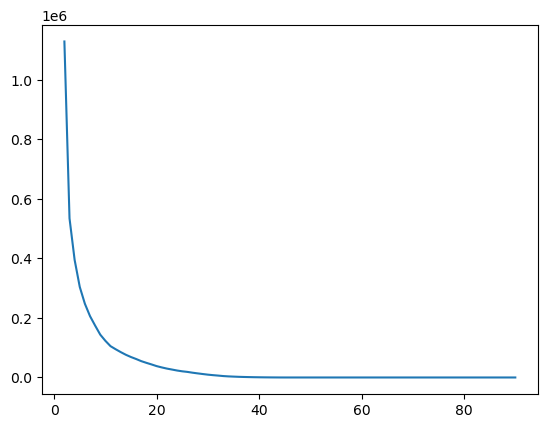

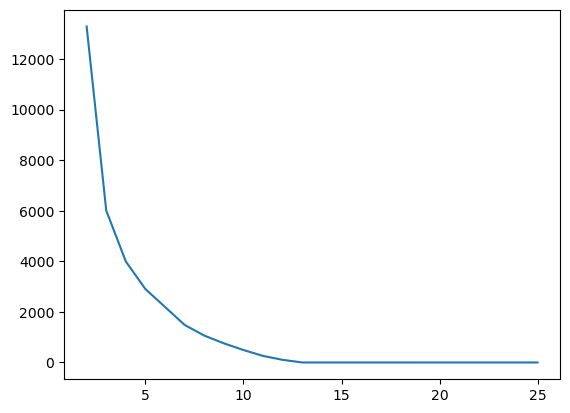

In [26]:
for city_id in [0,1]:
    print(f'City = {city_dict[city_id]}')
    plt.figure()
    plt.plot(nClus_to_obj_func[city_id].keys(),nClus_to_obj_func[city_id].values())

There's no really good way to say what the best number of clusters is, but the "elbow method" looks for where the above plots curve the most. That seems to be with about 10 clusters for Toronto, and 5 for Calgary. Let's see what these clusters look like!

In [27]:
def getNamesInClusters(clus_ids, clusters, id_to_name):
    cur_clusters = [clusters[clus_id][0] for clus_id in clus_ids]
    return [[id_to_name[x] for x in clus] for clus in cur_clusters]

# Toronto
print(f'City = {city_dict[0]}')
final_clusters = getNamesInClusters(clus_timeline[0][10],clusters_id[0],id_to_name[0])
for i, clus in enumerate(final_clusters):
    string = ''
    for name in clus:
        if name is clus[-1]:
            string += name
        else:
            string += name + ', '
    
    print(i+1,string)
    
print()

# Calgary
print(f'City = {city_dict[1]}')
final_clusters = getNamesInClusters(clus_timeline[1][5],clusters_id[1],id_to_name[1])
for i, clus in enumerate(final_clusters):
    string = ''
    for name in clus:
        if name is clus[-1]:
            string += name
        else:
            string += name + ', '
    
    print(i+1,string)
print()

City = Toronto
1 John Filion, Paula Fletcher, Joe Cressy, Mike Layton, Ceta Ramkhalawansingh, Joe Mihevc, Alejandra Bravo, Ausma Malik
2 Janet Davis, Shelley Carroll, A.A. Heaps, Gord Perks, Kristyn Wong-Tam, Neethan Shan, Chris Moise, Dianne Saxe
3 Anthony Perruzza, Raymond Cho, Glenn De Baeremaeker, Lucy Troisi, Maria Augimeri, Miganoush Megardichian, Amber Morley, Jamaal Myers
4 Norman Kelly, Paul Ainslie, Jonathan Tsao, Michael Thompson, Ron Moeser, Suzan Hall
5 Mike Del Grande, Rob Ford, Michael Ford, Stephen Holyday, Bill Saundercook, Giorgio Mammoliti
6 Denzil Minnan-Wong, John Parker, Cynthia Lai, Frances Nunziata, David Shiner, Mike Feldman
7 Jon Burnside, Josh Colle, Jennifer McKelvie, John Tory, Gloria Lindsay Luby, Peter Leon, Chin Lee, Michelle Berardinetti, Jim Karygiannis, Mike Colle, Brian Ashton, Case Ootes
8 Adam Vaughan, Sarah Doucette, Ana BailÃ£o, Brad Bradford, Howard Moscoe, Sandra Bussin, Mary Fragedakis, Pam McConnell, Adam Giambrone, David Miller, Josh Matlow,

So there we have it! I like to see Fords and Holydays generally placed together, and Tory with McKelvie also matches expectations. I'm a lot less knowledgeable about Calgary politics, but my brother who is a lot more in-the-know there says "That's largely correct. I'd accept that sorting". High praise indeed!

---

---

In [28]:
import networkx as nx

Let's store all the network graphs in the following style: `{city_id: {term_id: df/graph}}` so we can easily keep track of all our networks and the dataframes used to build them.

In [29]:
# Set up a dict to hold all output info
pivot_term_df = {}

# Set up a dict to keep track of when terms exist
terms = {}
terms[0] = clus_vote_df[0].Term.unique()
# Calgary's terms are not encoded into the data, we need to manually provide that information
terms[1] = ['2021-2025','2017-2021']

for city_id, df in clus_vote_df.items():
    print(f'City = {city_dict[city_id]}')
    
    # Set up each city to hold multiple terms
    pivot_term_df[city_id] = {}

    # All the information about the resolution, not the voter
    col_list = df.columns.drop(['Name','Vote']).to_list()

    # This maddening line collects all the resolution-based information and assigns a "vote_id" to each
    temp_df = df.groupby(col_list).size().reset_index().drop(columns=0).reset_index().rename(columns={'index':'vote_id'})
    
    # We merge this back into the original dataframe so we have a new "vote_id" column
    merge_df = pd.merge(left = temp_df, right = df, on = col_list, how='left')
    
    for term in terms[city_id]:
        if city_id == 0:
            term_df = merge_df.loc[merge_df.Term == term]

        elif city_id == 1:
            # Because of the way the Calgary data has no term identifier, we have to filter the data based on the meeting dates
            if term == '2021-2025':
                term_df = merge_df.loc[pd.to_datetime(merge_df.MeetingDate)>=pd.to_datetime('20211018', format='%Y%m%d')]
            elif term == '2017-2021':
                term_df = merge_df.loc[pd.to_datetime(merge_df.MeetingDate)<pd.to_datetime('20211018', format='%Y%m%d')]
            
        # To get ready to pivot, we only need the name, vote, and vote_id
        # We also need there to be no duplicates
        term_df = term_df.drop(columns=col_list).drop_duplicates(subset=['vote_id','Name'])

        # Finally pivot
        pivot_term_df[city_id][term] = term_df.pivot(index='vote_id', columns='Name', values='Vote')

        # And replace absences with NaNs since we're done evaluating attendance
        pivot_term_df[city_id][term] = pivot_term_df[city_id][term].replace('Absent',np.NaN)

City = Toronto
City = Calgary


In [30]:
#first get matrix for d_ij and n_ij, then use those to compute D_ij and w_ij
d_term_df = {}
n_term_df = {}

n_cutoff = 0

for city_id, term_df_dict in pivot_term_df.items():
    d_term_df[city_id] = {}
    n_term_df[city_id] = {}
    for term, df in term_df_dict.items():
        # Unfortunately I can't think of a clean way to do this in pandas without iterating through the columns, which is slower.
        # At least we can resolve only half the matrix and rely on symmetry to get the other half!
        all_cols = df.columns
        rem_cols = df.columns
        d_term_df[city_id][term] = pd.DataFrame(columns = all_cols, index = all_cols, dtype = int)
        for col1 in all_cols:
            rem_cols = rem_cols.drop(col1)
            # Doing this should ensure we have every unordered combination of col1, col2
            for col2 in rem_cols:
                # Disagreements are when both voters voted (not null) but voted differently
                d_term_df[city_id][term].at[col1,col2] = len(df.loc[df[col1].notnull() & df[col2].notnull() & (df[col1] != df[col2])])

        # reset rem_cols so we can loop through again 
        rem_cols = df.columns
        n_term_df[city_id][term] = pd.DataFrame(columns = all_cols, index = all_cols, dtype = int)
        for col1 in all_cols:
            rem_cols = rem_cols.drop(col1)
            for col2 in rem_cols:
                val = len(df.loc[df[col1].notnull() & df[col2].notnull()])
                # remove entries where n is less than the cutoff
                n_term_df[city_id][term].at[col1,col2] = val if val >= n_cutoff else np.NaN

        n_term_df[city_id][term] = n_term_df[city_id][term].replace(0,np.NaN)

In [31]:
# Create an agreement matrix
A_term_df = {}
for city_id, term_list in terms.items():
    A_term_df[city_id] = {}
    for term in term_list:
        a_df = n_term_df[city_id][term]-d_term_df[city_id][term]
        A_term_df[city_id][term] = (a_df+1) / (n_term_df[city_id][term]+2)

In [32]:
# Make agreement matrix symmetric, and make NA's into zeroes, and make diagonal into 1
for city_id, term_df_dict in A_term_df.items():
    for term, df in term_df_dict.items():
        cols = df.columns
        rem_cols = cols.copy()
        for col1 in cols:
            df.at[col1,col1] = 1
            rem_cols.drop(col1)
            for col2 in rem_cols:
                df.at[col2,col1] = df.at[col1,col2]
        df.fillna(0, inplace=True)

Voting similarity network for Toronto city council for the 2022-2026 term


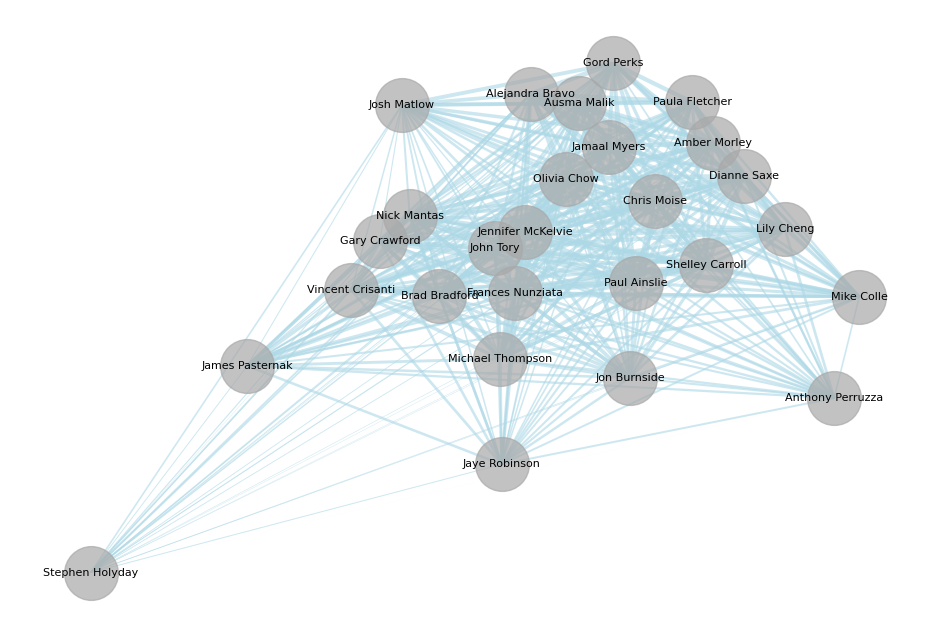

Voting similarity network for Toronto city council for the 2018-2022 term


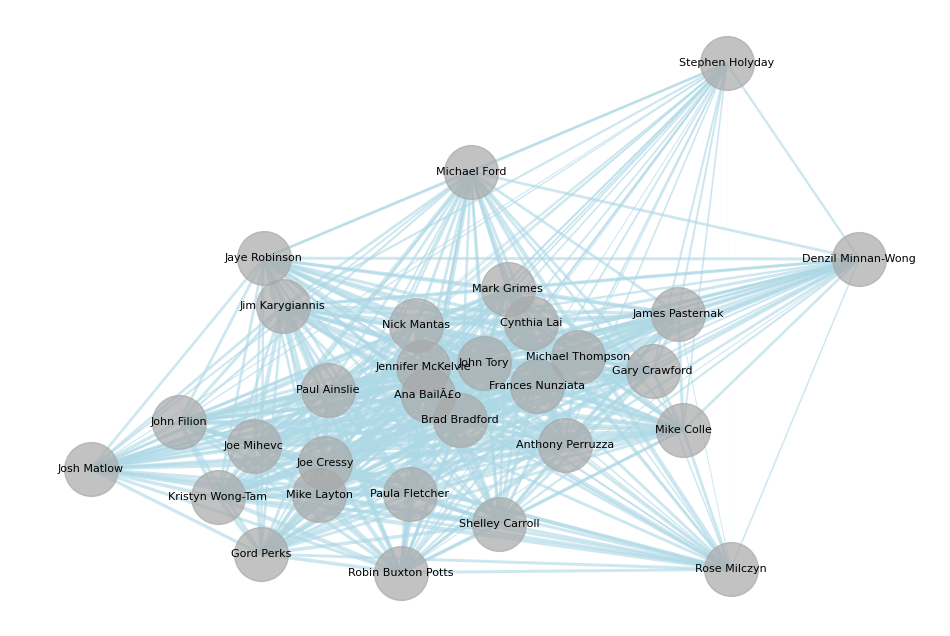

Voting similarity network for Toronto city council for the 2014-2018 term


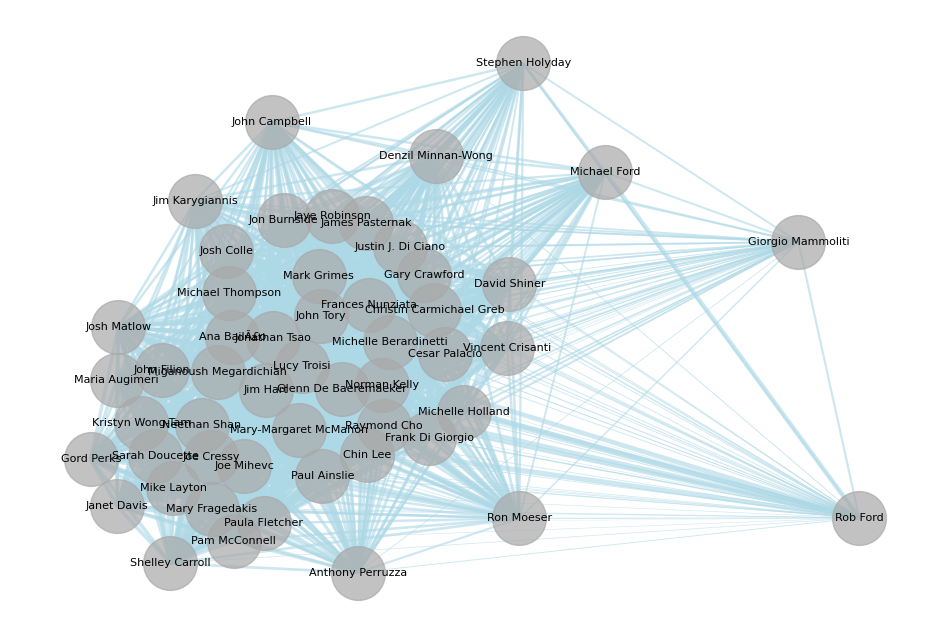

Voting similarity network for Toronto city council for the 2010-2014 term


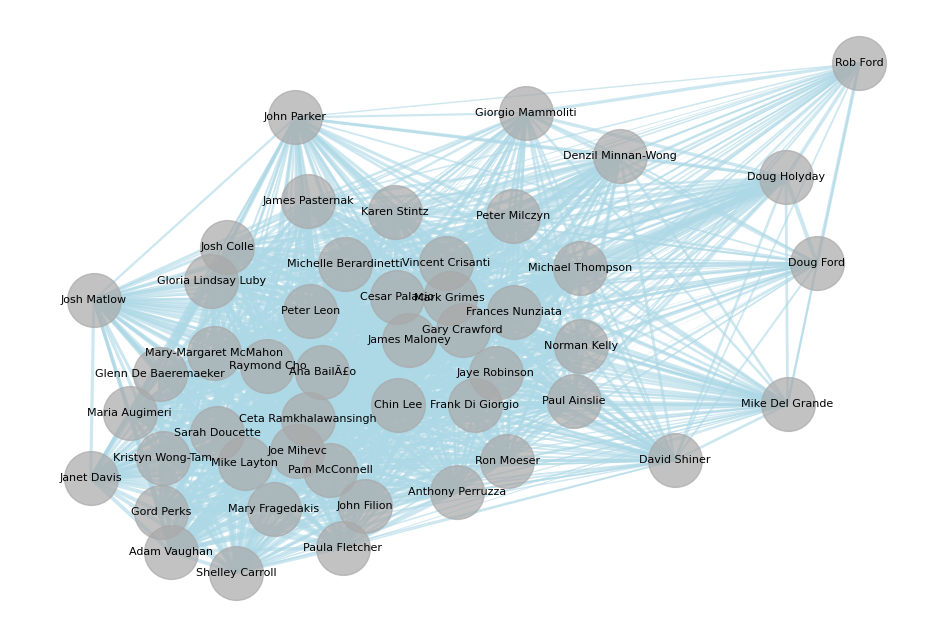

Voting similarity network for Toronto city council for the 2006-2010 term


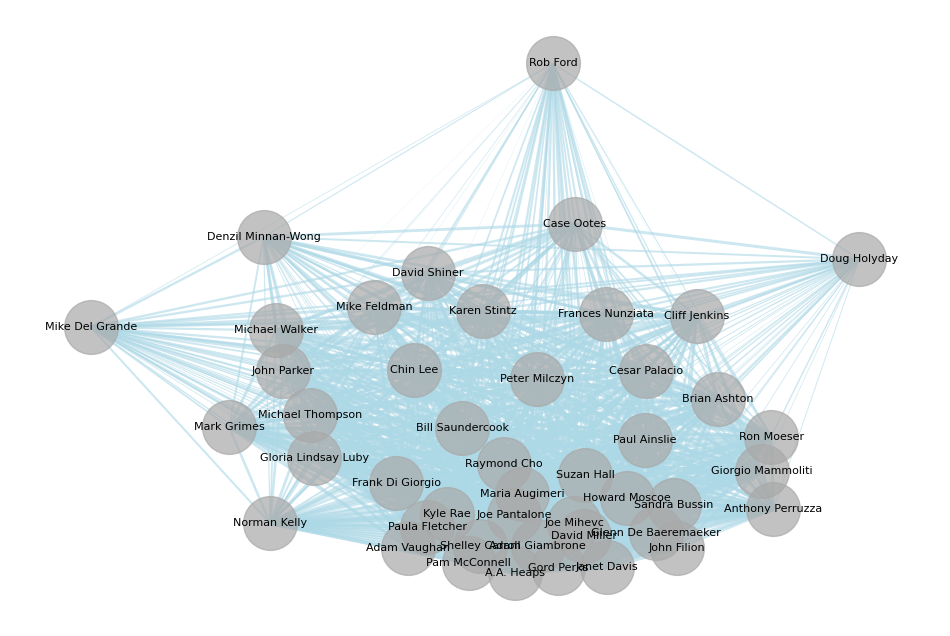

Voting similarity network for Calgary city council for the 2021-2025 term


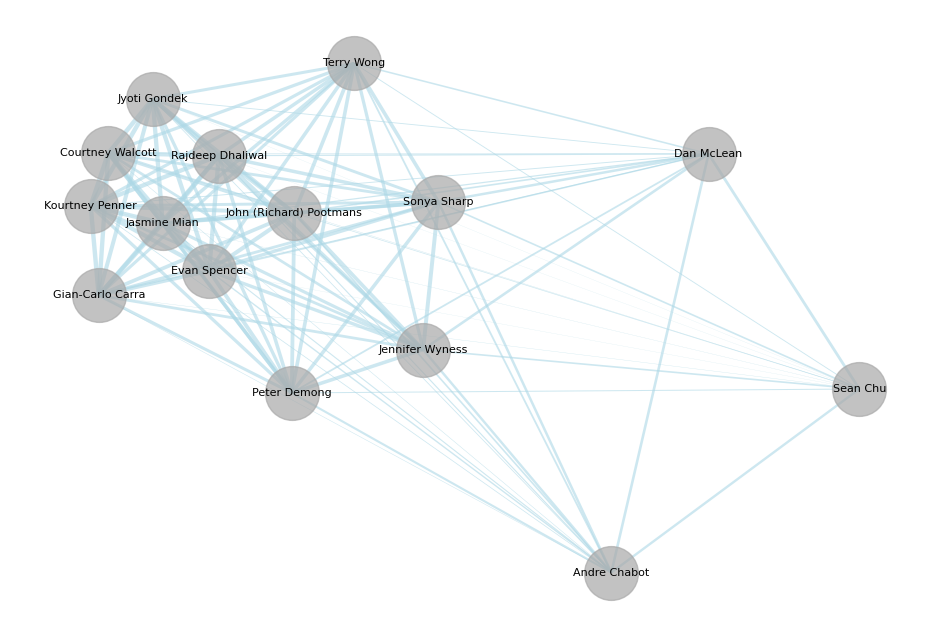

Voting similarity network for Calgary city council for the 2017-2021 term


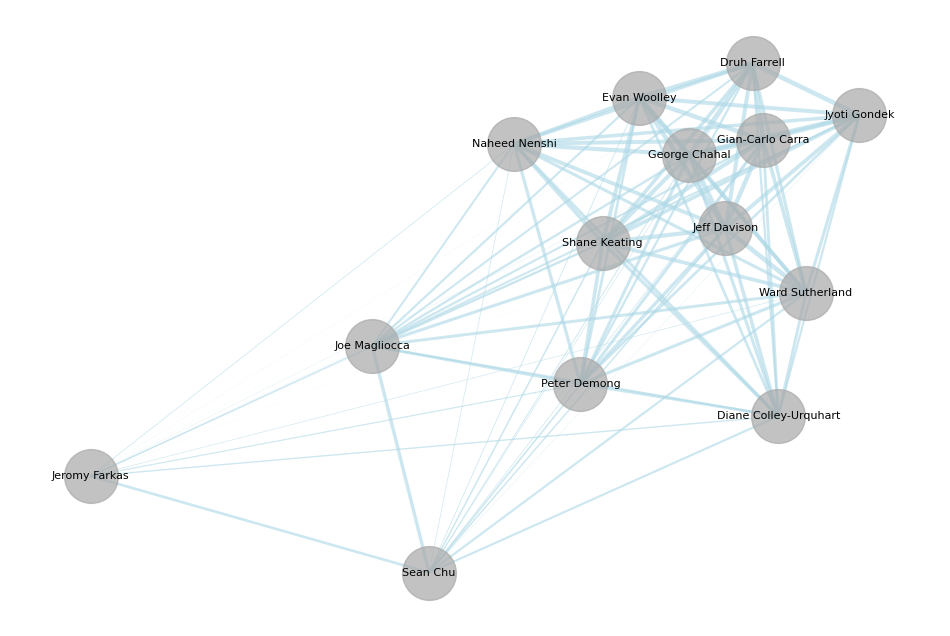

In [33]:
for city_id, term_df_dict in A_term_df.items():
    for term, df in term_df_dict.items():
        print(f'Voting similarity network for {city_dict[city_id]} city council for the {term} term')
        
        G=nx.from_pandas_adjacency(1-A_term_df[city_id][term])

        # Make network line thicknesses related to the strength of the connection between the two nodes (councillors)
        widths = nx.get_edge_attributes(G, 'weight')
        widths_mean = np.mean(list(widths.values()))
        widths_std = np.std(list(widths.values()))
        widths.update((x, -(y-widths_mean)/widths_std+2) for x, y in widths.items())

        nodelist = G.nodes()

        plt.figure(figsize=(12,8))

        # There are two reasonable options for the node locations: 
        # the spring_layout seems to have difficulty with prioritizing keeping nodes from overlapping too much
        #pos = nx.spring_layout(G,weight='weight')
        pos = nx.kamada_kawai_layout(G,weight='weight')
        nx.draw_networkx_nodes(G,pos,
                               nodelist=nodelist,
                               node_size=1500,
                               node_color='darkgrey',
                               alpha=0.7)
        nx.draw_networkx_edges(G,pos,
                               edgelist = widths.keys(),
                               width=list(widths.values()),
                               edge_color='lightblue',
                               alpha=0.6)
        nx.draw_networkx_labels(G, pos=pos,
                                labels=dict(zip(nodelist,nodelist)),
                                font_color='black',
                                font_size = 8)
        plt.box(False)
        plt.show()